# Plot Performance Over All Sessions
Use this notebook to plot subject performance over all three sessions, and to run stats on them too. Load models created through the simulate everything notebook (use 'experimental' for simulating with correct baseline and scaling calculations on what would be the original models).

## WARNING
Before running this notebook, make sure you have simulated all 3 sessions for the subject of interest using `Simulate_Everything_with_Different_Models`

Nile Wilson, 2019.03.06

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
from scipy.stats import sem
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne
import os

# Set Your Variables
Define which subject's data you are going to use to simulate performance (be sure to make sure the subject_group and session_number are correct)

In [2]:
subjID = '851238'
subject_group = 1
EEGdevice = 8
useBehavioral = False # True for collection 2, False for collection 1

# model_type will be used to name/organize all files associated with whatever you run here
# don't use the word 'original' here
# Usually either 'experimental' or 'SVM01'
model_type = 'SVM01'

# PART 1: Load all the data
Load in all the models and the associated data

### Function Definitions
Functions for working with the BCI data

In [3]:
def FindBCIFiles(subjID, run_number, session_number, model_type):
    """
    Returns the file names for the BCI run of choice
    """
    # Load latest model and its associated data
    BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
    
    # Throw exception if model number is outside range of existing models
    if run_number-1 > len(BCI_files):
        raise ValueError('Please select a valid run number')
    
    filename_eeg = BCI_files[run_number-1]
    print('Selecting BCI EEG file: ' + filename_eeg)

    behavioral_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/BCI_' + subjID + '*.csv')
    filename_behavioral = behavioral_files[run_number-1]
    print('Selecting BCI behavioral file: ' + filename_behavioral)
    
    return filename_eeg, filename_behavioral

def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

def EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(2.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        # Note, baseline is filtered before it is used in the live script
        baseline_pre_filt = np.asarray(EEGdata.loc[tb_start:tb_end][channels]) * 1.0
        baseline_filt = filter_data(baseline_pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        baseline = baseline_filt.T

        # Filter per epoch, like you would in real-time
        pre_filt = np.asarray(EEGdata.loc[t_start:t_end][channels]) * 1.0
        filtered = filter_data(pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        epoch = pd.DataFrame(filtered.T)
        epoch.columns = EEGdata.columns[0:8]

        # Store epoch
        tmp = (epoch - np.mean(baseline,0))/np.std(baseline,0)
        tmp = pd.DataFrame(tmp)
        tmp.columns = EEGdata.columns[0:8]

        epochs_norm.append(tmp)
        epochs.append(epoch)

    return epochs, epochs_norm

def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When the target is to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    
    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) >= 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) >= 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

def LoadModel_MI(subjID, model_type, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt = run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    if runOfInt == 1:
        models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    else:
        if adaptationType == 'CS' or adaptationType == 'None':
            models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
            models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
        elif adaptationType == 'TL':
            models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
            models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = run_number -1
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

def GetBehavioralTL(runOfInt, behavioralData_all, hasBaseline_all):
    # When the target is to the left
    trialL = np.where(behavioralData_all[runOfInt]['target_x'] < 1000)
    movementL = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'left')

    # When target was to the right
    trialR = np.where(behavioralData_all[runOfInt]['target_x'] > 1000)
    movementR = np.where(behavioralData_all[runOfInt]['direction_moved'] == 'right')

    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1
    trial_type = np.round(trial_type[0])

    direction_moved = np.zeros([1,len(behavioralData_all[runOfInt]['score'])])
    direction_moved[0][movementL] = 0
    direction_moved[0][movementR] = 1
    direction_moved = np.round(direction_moved[0])

    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline_all[runOfInt])):
        if hasBaseline_all[runOfInt][movement] is False:
            trial_type = np.delete(trial_type, movement)
            direction_moved = np.delete(direction_moved, movement)
    
    actual = direction_moved
    TL = trial_type
    return actual, TL

def GetBehavioralTL_single(runOfInt, behavioralData, hasBaseline):
    # When the target is to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    movementL = np.where(behavioralData['direction_moved'] == 'left')

    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    movementR = np.where(behavioralData['direction_moved'] == 'right')

    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1
    trial_type = np.round(trial_type[0])

    direction_moved = np.zeros([1,len(behavioralData['score'])])
    direction_moved[0][movementL] = 0
    direction_moved[0][movementR] = 1
    direction_moved = np.round(direction_moved[0])

    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            direction_moved = np.delete(direction_moved, movement)
    
    actual = direction_moved
    TL = trial_type
    return actual, TL

In [4]:
# Load latest model and its associated data
BCI_files = glob.glob('SaveData/' + subjID + '/Session1/*' + subjID + '_BCI.easy')
num_of_runs = len(BCI_files)

In [5]:
# Check that this is correct
print('Detected number of BCI runs: ' + str(num_of_runs))

Detected number of BCI runs: 5


## Individual Subject

Run in a loop

In [6]:
orig_scores = list()
sim_scores = list()
sim_TL_scores = list()
X_orig_all = dict()
y_orig_all = dict()
X_sim_all = dict()
y_sim_all = dict()
X_sim_TL_all = dict()
y_sim_TL_all = dict()
clf_orig_all = dict()
clf_sim_all = dict()
clf_sim_TL_all = dict() # for simulated true-label adaptation
behavioralData_all = dict()
hasBaseline_all = dict()
counter = 1 # keeps track of all runs (start from 1->15)

for session_number in range(1,3+1):
    for runOfInt in range(1, num_of_runs+1):
        # Find BCI file names
        filename_eeg, filename_behavioral = FindBCIFiles(subjID, runOfInt, session_number, model_type)

        # Load EEG data
        EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

        # Load behavioral data
        behavioralData = LoadBehavioralDataBCI(filename_behavioral)
        behavioralData_all[counter] = behavioralData

        # Sync up trigger pulses
        num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)
        hasBaseline_all[counter] = hasBaseline

        # Epoch the data
        epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

        # Organize trial types
        trial_type = OrganizeTrials(behavioralData, hasBaseline)

        # Get signal features
        alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
        motor_features = [alpha_power['C3'], beta_power['C3'], alpha_power['C4'], beta_power['C4']]
        motor_features = np.transpose(motor_features)

        # Load a specific model (0 loads initial model trained on screening)
        # If using run_number, it will load the model created just prior to
        # this BCI run (simulated or created during the session)
        if subject_group == 1:
            clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
        elif subject_group == 2:
            clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')

        # Get the original score
        X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
        y = trial_type
        orig_score = clf_orig.score(X, y)*100
        X_orig_all[counter] = X
        y_orig_all[counter] = y

        # Get the simulated score (no adaptation or CS adaptation)
        if subject_group == 1:
            clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')
        elif subject_group == 2:
            clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')

        X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
        y = trial_type
        sim_score = clf_sim.score(X, y)*100
        X_sim_all[counter] = X
        y_sim_all[counter] = y

        # Get the true label simulation score
        if runOfInt == 1:
            clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
        else:
            clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'TL')
        X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
        y = trial_type
        sim_TL_score = clf_sim_TL.score(X, y)*100
        X_sim_TL_all[counter] = X
        y_sim_TL_all[counter] = y

        # Store values
        orig_scores.append(orig_score)
        sim_scores.append(sim_score)
        sim_TL_scores.append(sim_TL_score)
        clf_orig_all[counter] = clf_orig
        clf_sim_all[counter] = clf_sim
        clf_sim_TL_all[counter] = clf_sim_TL
        counter += 1

Selecting BCI EEG file: SaveData/851238/Session1\20190401150511_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401150958_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-30.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-30.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401151511_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-32.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-34.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401152017_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-36.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-36.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401152508_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-39.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-40.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404134320_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404134839_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-26.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-26.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404135329_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-28.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-29.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404135831_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-31.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-32.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404140340_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-34.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-35.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405161700_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405162133_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-21.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-21.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405162614_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-23.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-24.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405163100_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-26.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-27.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405163545_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-29.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-30.sav


Note that the overall simulated BCI performance may be better if you do a one-time filter on all the data prior to epoching, but to keep this a true simulation, we filter per epoch here.

In [7]:
actual_scores = list()
for runOfInt in range(1,15+1):
    actual, TL = GetBehavioralTL(runOfInt, behavioralData_all, hasBaseline_all)
    correct_all = len(np.where(TL==actual)[0])/len(TL)*100
    actual_scores.append(correct_all)

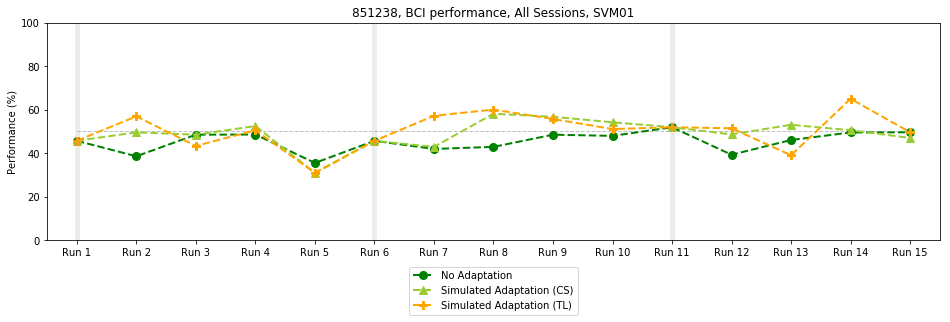

In [8]:
fig = plt.figure(figsize=(16,4))
if subject_group == 1:
    if useBehavioral is True:
        plt.plot(actual_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    else:
        plt.plot(orig_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.title(subjID + ', BCI performance, All Sessions, ' + model_type)
    lgd = plt.legend(['No Adaptation','Simulated Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
    
elif subject_group == 2:
    plt.plot(sim_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    if useBehavioral is True:
        plt.plot(actual_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    else:
        plt.plot(orig_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.title(subjID + ', BCI performance, All Sessions, ' + model_type)
    lgd = plt.legend(['Simulated No Adaptation','Co-Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
# Plot properties
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
           ['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6','Run 7','Run 8','Run 9','Run 10',
           'Run 11','Run 12','Run 13','Run 14','Run 15'])
plt.ylabel('Performance (%)')
plt.hlines(y=50, xmin=0, xmax=14, color='gray', linestyles='dashed',
           linewidth=1, alpha=0.5)
plt.axvline(x=0, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=5, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=10, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.ylim([0, 100])
plt.xlim([-0.5,14.5])

plt.show()
fig.savefig('Figures/' + subjID + '/' + model_type + '/' + subjID + '_Performance_Session-all.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

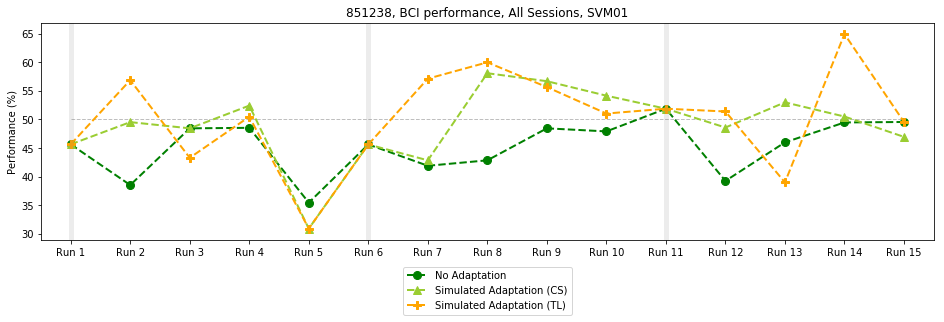

In [9]:
min_all = np.min([np.min(orig_scores),np.min(sim_scores),np.min(sim_TL_scores)])
max_all = np.max([np.max(orig_scores),np.max(sim_scores),np.max(sim_TL_scores)])

fig = plt.figure(figsize=(16,4))
if subject_group == 1:
    if useBehavioral is True:
        plt.plot(actual_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    else:
        plt.plot(orig_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.title(subjID + ', BCI performance, All Sessions, ' + model_type)
    lgd = plt.legend(['No Adaptation','Simulated Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
    
elif subject_group == 2:
    plt.plot(sim_scores, color='green', marker='o', markersize=8,
             linestyle='dashed', linewidth=2)
    if useBehavioral is True:
        plt.plot(actual_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    else:
        plt.plot(orig_scores, color='yellowgreen', marker='^', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=8,
             linestyle='dashed', linewidth=2)
    plt.title(subjID + ', BCI performance, All Sessions, ' + model_type)
    lgd = plt.legend(['Simulated No Adaptation','Co-Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
# Plot properties
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
           ['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6','Run 7','Run 8','Run 9','Run 10',
           'Run 11','Run 12','Run 13','Run 14','Run 15'])
plt.ylabel('Performance (%)')
plt.hlines(y=50, xmin=0, xmax=14, color='gray', linestyles='dashed',
           linewidth=1, alpha=0.5)
plt.axvline(x=0, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=5, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=10, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.ylim([min_all-2, max_all+2])
plt.xlim([-0.5,14.5])

plt.show()
fig.savefig('Figures/' + subjID + '/' + model_type + '/' + subjID + '_Performance_Session-all_zoom.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

## All Subjects
Plot average across all subjects

In [10]:
demographics_all = pd.read_csv('subject_demographics.csv')

# Drop the sleeping subject
demographics_all = demographics_all.drop(demographics_all.loc[demographics_all['Subject ID'] == '97e442'].index[0])

# Store some data
subjID_all = list(demographics_all['Subject ID'])
subject_group_all = list(demographics_all['Group Number'])
studyNumber_all = np.asarray(demographics_all['Study Number'])
handedness_all = list(demographics_all['Handedness'])
age_all = np.asarray(demographics_all['Age'])

demographics_all.head()

,Subject ID,Group Number,Moving MI,Session 1,Session 2,Session 3,Handedness,Sex,Age,History of Neurological Disorders,Cap Size,Study Number
0,b12a46,1,No,0,8,15,R,M,21,No,M,1
1,41d8ff,1,No,0,5,12,R,F,21,No,M,1
2,1e8b34,1,No,0,3,14,R,M,29,No,L,1
3,ad11cf,1,No,0,7,12,R,F,20,Yes,M,1
4,b7ff16,2,No,0,19,21,R,F,20,No,M,1


Update the `subject_count` tracking to work with demographics table stuff (should be easier)

In [11]:
orig_scores = list()
sim_scores = list()
sim_TL_scores = list()
actual_scores = list()
X_orig_all = dict()
y_orig_all = dict()
X_sim_all = dict()
y_sim_all = dict()
X_sim_TL_all = dict()
y_sim_TL_all = dict()
clf_orig_all = dict()
clf_sim_all = dict()
clf_sim_TL_all = dict() # for simulated true-label adaptation

subject_count = 0

for subjID in subjID_all:
    subject_group = subject_group_all[subject_count]
    counter = 1 # keeps track of all runs (start from 1->15)
    
    for session_number in range(1,3+1):
        for runOfInt in range(1, num_of_runs+1):
            # Find BCI file names
            filename_eeg, filename_behavioral = FindBCIFiles(subjID, runOfInt, session_number, model_type)

            # Load EEG data
            EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

            # Load behavioral data
            behavioralData = LoadBehavioralDataBCI(filename_behavioral)

            # Sync up trigger pulses
            num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

            # Epoch the data
            epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

            # Organize trial types
            trial_type = OrganizeTrials(behavioralData, hasBaseline)

            # Get signal features
            alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
            motor_features = [alpha_power['C3'], beta_power['C3'], alpha_power['C4'], beta_power['C4']]
            motor_features = np.transpose(motor_features)

            # Load a specific model (0 loads initial model trained on screening)
            # If using run_number, it will load the model created just prior to
            # this BCI run (simulated or created during the session)
            if subject_group == 1:
                clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
            elif subject_group == 2:
                clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')

            # Get the original score
            X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
            y = trial_type
            orig_score = clf_orig.score(X, y)*100
            X_orig_all[counter] = X
            y_orig_all[counter] = y

            # Get the simulated score (no adaptation or CS adaptation)
            if subject_group == 1:
                clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')
            elif subject_group == 2:
                clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')

            X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
            y = trial_type
            sim_score = clf_sim.score(X, y)*100
            X_sim_all[counter] = X
            y_sim_all[counter] = y

            # Get the true label simulation score
            if runOfInt == 1:
                clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
            else:
                clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'TL')
            X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
            y = trial_type
            sim_TL_score = clf_sim_TL.score(X, y)*100
            X_sim_TL_all[counter] = X
            y_sim_TL_all[counter] = y
            
            # Get behavioral score for not simulated
            actual, TL = GetBehavioralTL_single(runOfInt, behavioralData, hasBaseline)
            correct_all = len(np.where(TL==actual)[0])/len(TL)*100
            actual_scores.append(correct_all)

            # Store values
            orig_scores.append(orig_score)
            sim_scores.append(sim_score)
            sim_TL_scores.append(sim_TL_score)
            clf_orig_all[counter] = clf_orig
            clf_sim_all[counter] = clf_sim
            clf_sim_TL_all[counter] = clf_sim_TL
            counter += 1
        
    subject_count += 1

Selecting BCI EEG file: SaveData/b12a46/Session1\20190206095241_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session1\BCI_b12a46_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting BCI EEG file: SaveData/b12a46/Session1\20190206095756_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session1\BCI_b12a46_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-14.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_TL_2019-03-15-11-45-14.sav
Selecting BCI EEG file: SaveData/b12a46/Session1\20190206100259_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session1\BCI_b12a46_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-16.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_TL_2019-03-15-11-45-17.sav
Selecting BCI EEG file: SaveData/b12a46/Session1\20190206100731_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session1\BCI_b12a46_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-19.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_TL_2019-03-15-11-45-20.sav
Selecting BCI EEG file: SaveData/b12a46/Session1\20190206101239_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session1\BCI_b12a46_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-10.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_2019-03-15-11-45-22.sav
Selecting model: Models/b12a46/SVM01/Session1\b12a46_MI_classifier_TL_2019-03-15-11-45-23.sav
Selecting BCI EEG file: SaveData/b12a46/Session2\20190214161532_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session2\BCI_b12a46_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting BCI EEG file: SaveData/b12a46/Session2\20190214162030_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session2\BCI_b12a46_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-10.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_TL_2019-03-15-11-46-10.sav
Selecting BCI EEG file: SaveData/b12a46/Session2\20190214162551_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session2\BCI_b12a46_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-12.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_TL_2019-03-15-11-46-13.sav
Selecting BCI EEG file: SaveData/b12a46/Session2\20190214163053_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session2\BCI_b12a46_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-16.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_TL_2019-03-15-11-46-17.sav
Selecting BCI EEG file: SaveData/b12a46/Session2\20190214163546_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session2\BCI_b12a46_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-06.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_2019-03-15-11-46-19.sav
Selecting model: Models/b12a46/SVM01/Session2\b12a46_MI_classifier_TL_2019-03-15-11-46-20.sav
Selecting BCI EEG file: SaveData/b12a46/Session3\20190221131719_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session3\BCI_b12a46_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting BCI EEG file: SaveData/b12a46/Session3\20190221132158_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session3\BCI_b12a46_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-08.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_TL_2019-03-15-11-47-08.sav
Selecting BCI EEG file: SaveData/b12a46/Session3\20190221132631_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session3\BCI_b12a46_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-11.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_TL_2019-03-15-11-47-12.sav
Selecting BCI EEG file: SaveData/b12a46/Session3\20190221133107_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session3\BCI_b12a46_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-14.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_TL_2019-03-15-11-47-15.sav
Selecting BCI EEG file: SaveData/b12a46/Session3\20190221133532_b12a46_BCI.easy
Selecting BCI behavioral file: SaveData/b12a46/Session3\BCI_b12a46_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-05.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_2019-03-15-11-47-17.sav
Selecting model: Models/b12a46/SVM01/Session3\b12a46_MI_classifier_TL_2019-03-15-11-47-18.sav
Selecting BCI EEG file: SaveData/41d8ff/Session1\20190208110521_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session1\BCI_41d8ff_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting BCI EEG file: SaveData/41d8ff/Session1\20190208111006_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session1\BCI_41d8ff_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-13.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_TL_2019-03-15-11-39-13.sav
Selecting BCI EEG file: SaveData/41d8ff/Session1\20190208111516_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session1\BCI_41d8ff_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-15.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_TL_2019-03-15-11-39-16.sav
Selecting BCI EEG file: SaveData/41d8ff/Session1\20190208112000_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session1\BCI_41d8ff_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-18.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_TL_2019-03-15-11-39-19.sav
Selecting BCI EEG file: SaveData/41d8ff/Session1\20190208112500_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session1\BCI_41d8ff_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-10.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_2019-03-15-11-39-22.sav
Selecting model: Models/41d8ff/SVM01/Session1\41d8ff_MI_classifier_TL_2019-03-15-11-39-23.sav
Selecting BCI EEG file: SaveData/41d8ff/Session2\20190213162736_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session2\BCI_41d8ff_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting BCI EEG file: SaveData/41d8ff/Session2\20190213163354_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session2\BCI_41d8ff_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-09.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_TL_2019-03-15-11-40-09.sav
Selecting BCI EEG file: SaveData/41d8ff/Session2\20190213163925_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session2\BCI_41d8ff_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-11.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_TL_2019-03-15-11-40-12.sav
Selecting BCI EEG file: SaveData/41d8ff/Session2\20190213164437_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session2\BCI_41d8ff_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-14.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_TL_2019-03-15-11-40-15.sav
Selecting BCI EEG file: SaveData/41d8ff/Session2\20190213164952_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session2\BCI_41d8ff_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-05.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_2019-03-15-11-40-17.sav
Selecting model: Models/41d8ff/SVM01/Session2\41d8ff_MI_classifier_TL_2019-03-15-11-40-18.sav
Selecting BCI EEG file: SaveData/41d8ff/Session3\20190220162544_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session3\BCI_41d8ff_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting BCI EEG file: SaveData/41d8ff/Session3\20190220163138_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session3\BCI_41d8ff_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-05.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_TL_2019-03-15-11-41-05.sav
Selecting BCI EEG file: SaveData/41d8ff/Session3\20190220163743_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session3\BCI_41d8ff_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-07.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_TL_2019-03-15-11-41-08.sav
Selecting BCI EEG file: SaveData/41d8ff/Session3\20190220164326_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session3\BCI_41d8ff_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-11.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_TL_2019-03-15-11-41-12.sav
Selecting BCI EEG file: SaveData/41d8ff/Session3\20190220164846_41d8ff_BCI.easy
Selecting BCI behavioral file: SaveData/41d8ff/Session3\BCI_41d8ff_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-01.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_2019-03-15-11-41-14.sav
Selecting model: Models/41d8ff/SVM01/Session3\41d8ff_MI_classifier_TL_2019-03-15-11-41-15.sav
Selecting BCI EEG file: SaveData/1e8b34/Session1\20190219105435_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session1\BCI_1e8b34_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting BCI EEG file: SaveData/1e8b34/Session1\20190219105935_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session1\BCI_1e8b34_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-03.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_TL_2019-03-15-11-26-03.sav
Selecting BCI EEG file: SaveData/1e8b34/Session1\20190219110440_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session1\BCI_1e8b34_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-06.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_TL_2019-03-15-11-26-07.sav
Selecting BCI EEG file: SaveData/1e8b34/Session1\20190219110951_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session1\BCI_1e8b34_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-09.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_TL_2019-03-15-11-26-10.sav
Selecting BCI EEG file: SaveData/1e8b34/Session1\20190219111454_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session1\BCI_1e8b34_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-00.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_2019-03-15-11-26-13.sav
Selecting model: Models/1e8b34/SVM01/Session1\1e8b34_MI_classifier_TL_2019-03-15-11-26-14.sav
Selecting BCI EEG file: SaveData/1e8b34/Session2\20190222091035_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session2\BCI_1e8b34_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting BCI EEG file: SaveData/1e8b34/Session2\20190222091511_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session2\BCI_1e8b34_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-27-01.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_TL_2019-03-15-11-27-01.sav
Selecting BCI EEG file: SaveData/1e8b34/Session2\20190222091957_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session2\BCI_1e8b34_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-27-04.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_TL_2019-03-15-11-27-04.sav
Selecting BCI EEG file: SaveData/1e8b34/Session2\20190222092458_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session2\BCI_1e8b34_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-27-07.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_TL_2019-03-15-11-27-08.sav
Selecting BCI EEG file: SaveData/1e8b34/Session2\20190222092951_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session2\BCI_1e8b34_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-26-58.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_2019-03-15-11-27-10.sav
Selecting model: Models/1e8b34/SVM01/Session2\1e8b34_MI_classifier_TL_2019-03-15-11-27-11.sav
Selecting BCI EEG file: SaveData/1e8b34/Session3\20190305091455_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session3\BCI_1e8b34_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting BCI EEG file: SaveData/1e8b34/Session3\20190305092025_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session3\BCI_1e8b34_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-56.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_TL_2019-03-15-11-27-56.sav
Selecting BCI EEG file: SaveData/1e8b34/Session3\20190305092514_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session3\BCI_1e8b34_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-58.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_TL_2019-03-15-11-27-59.sav
Selecting BCI EEG file: SaveData/1e8b34/Session3\20190305092953_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session3\BCI_1e8b34_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-28-02.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_TL_2019-03-15-11-28-03.sav
Selecting BCI EEG file: SaveData/1e8b34/Session3\20190305093437_1e8b34_BCI.easy
Selecting BCI behavioral file: SaveData/1e8b34/Session3\BCI_1e8b34_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-27-53.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_2019-03-15-11-28-05.sav
Selecting model: Models/1e8b34/SVM01/Session3\1e8b34_MI_classifier_TL_2019-03-15-11-28-06.sav
Selecting BCI EEG file: SaveData/ad11cf/Session1\20190215163750_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session1\BCI_ad11cf_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting BCI EEG file: SaveData/ad11cf/Session1\20190215164229_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session1\BCI_ad11cf_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-42-01.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_TL_2019-03-15-10-42-01.sav
Selecting BCI EEG file: SaveData/ad11cf/Session1\20190215164725_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session1\BCI_ad11cf_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-42-03.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_TL_2019-03-15-10-42-05.sav
Selecting BCI EEG file: SaveData/ad11cf/Session1\20190215165214_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session1\BCI_ad11cf_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-42-07.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_TL_2019-03-15-10-42-08.sav
Selecting BCI EEG file: SaveData/ad11cf/Session1\20190215165729_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session1\BCI_ad11cf_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-41-57.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_2019-03-15-10-42-11.sav
Selecting model: Models/ad11cf/SVM01/Session1\ad11cf_MI_classifier_TL_2019-03-15-10-42-12.sav
Selecting BCI EEG file: SaveData/ad11cf/Session2\20190222161801_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session2\BCI_ad11cf_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting BCI EEG file: SaveData/ad11cf/Session2\20190222162254_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session2\BCI_ad11cf_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-43-01.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_TL_2019-03-15-10-43-01.sav
Selecting BCI EEG file: SaveData/ad11cf/Session2\20190222162742_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session2\BCI_ad11cf_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-43-04.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_TL_2019-03-15-10-43-05.sav
Selecting BCI EEG file: SaveData/ad11cf/Session2\20190222163217_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session2\BCI_ad11cf_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-43-07.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_TL_2019-03-15-10-43-08.sav
Selecting BCI EEG file: SaveData/ad11cf/Session2\20190222163652_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session2\BCI_ad11cf_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-42-57.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_2019-03-15-10-43-10.sav
Selecting model: Models/ad11cf/SVM01/Session2\ad11cf_MI_classifier_TL_2019-03-15-10-43-11.sav
Selecting BCI EEG file: SaveData/ad11cf/Session3\20190227091743_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session3\BCI_ad11cf_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting BCI EEG file: SaveData/ad11cf/Session3\20190227092229_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session3\BCI_ad11cf_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-58.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_TL_2019-03-15-10-43-58.sav
Selecting BCI EEG file: SaveData/ad11cf/Session3\20190227092713_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session3\BCI_ad11cf_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-44-01.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_TL_2019-03-15-10-44-02.sav
Selecting BCI EEG file: SaveData/ad11cf/Session3\20190227093159_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session3\BCI_ad11cf_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-44-04.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_TL_2019-03-15-10-44-05.sav
Selecting BCI EEG file: SaveData/ad11cf/Session3\20190227093708_ad11cf_BCI.easy
Selecting BCI behavioral file: SaveData/ad11cf/Session3\BCI_ad11cf_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-43-55.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_2019-03-15-10-44-07.sav
Selecting model: Models/ad11cf/SVM01/Session3\ad11cf_MI_classifier_TL_2019-03-15-10-44-08.sav
Selecting BCI EEG file: SaveData/b7ff16/Session1\20190207163753_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session1\BCI_b7ff16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting BCI EEG file: SaveData/b7ff16/Session1\20190207164347_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session1\BCI_b7ff16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-08.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_TL_2019-03-15-11-56-08.sav
Selecting BCI EEG file: SaveData/b7ff16/Session1\20190207164859_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session1\BCI_b7ff16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-10.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_TL_2019-03-15-11-56-11.sav
Selecting BCI EEG file: SaveData/b7ff16/Session1\20190207165403_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session1\BCI_b7ff16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-13.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_TL_2019-03-15-11-56-14.sav
Selecting BCI EEG file: SaveData/b7ff16/Session1\20190207165849_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session1\BCI_b7ff16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-17.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_2019-03-15-11-56-04.sav
Selecting model: Models/b7ff16/SVM01/Session1\b7ff16_MI_classifier_TL_2019-03-15-11-56-18.sav
Selecting BCI EEG file: SaveData/b7ff16/Session2\20190226144836_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session2\BCI_b7ff16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting BCI EEG file: SaveData/b7ff16/Session2\20190226145330_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session2\BCI_b7ff16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-06.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_TL_2019-03-15-11-57-06.sav
Selecting BCI EEG file: SaveData/b7ff16/Session2\20190226145850_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session2\BCI_b7ff16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-08.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_TL_2019-03-15-11-57-09.sav
Selecting BCI EEG file: SaveData/b7ff16/Session2\20190226150409_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session2\BCI_b7ff16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-11.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_TL_2019-03-15-11-57-12.sav
Selecting BCI EEG file: SaveData/b7ff16/Session2\20190226150923_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session2\BCI_b7ff16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-15.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_2019-03-15-11-57-02.sav
Selecting model: Models/b7ff16/SVM01/Session2\b7ff16_MI_classifier_TL_2019-03-15-11-57-16.sav
Selecting BCI EEG file: SaveData/b7ff16/Session3\20190228091607_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session3\BCI_b7ff16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting BCI EEG file: SaveData/b7ff16/Session3\20190228092046_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session3\BCI_b7ff16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-04.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_TL_2019-03-15-11-58-04.sav
Selecting BCI EEG file: SaveData/b7ff16/Session3\20190228092535_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session3\BCI_b7ff16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-07.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_TL_2019-03-15-11-58-08.sav
Selecting BCI EEG file: SaveData/b7ff16/Session3\20190228093024_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session3\BCI_b7ff16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-10.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_TL_2019-03-15-11-58-11.sav
Selecting BCI EEG file: SaveData/b7ff16/Session3\20190228093513_b7ff16_BCI.easy
Selecting BCI behavioral file: SaveData/b7ff16/Session3\BCI_b7ff16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-13.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_2019-03-15-11-58-01.sav
Selecting model: Models/b7ff16/SVM01/Session3\b7ff16_MI_classifier_TL_2019-03-15-11-58-14.sav
Selecting BCI EEG file: SaveData/42feb7/Session1\20190305133127_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session1\BCI_42feb7_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting BCI EEG file: SaveData/42feb7/Session1\20190305133646_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session1\BCI_42feb7_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-37.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_TL_2019-03-15-12-01-38.sav
Selecting BCI EEG file: SaveData/42feb7/Session1\20190305134224_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session1\BCI_42feb7_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-40.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_TL_2019-03-15-12-01-41.sav
Selecting BCI EEG file: SaveData/42feb7/Session1\20190305134736_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session1\BCI_42feb7_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-43.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_TL_2019-03-15-12-01-44.sav
Selecting BCI EEG file: SaveData/42feb7/Session1\20190305135304_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session1\BCI_42feb7_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-47.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_2019-03-15-12-01-34.sav
Selecting model: Models/42feb7/SVM01/Session1\42feb7_MI_classifier_TL_2019-03-15-12-01-48.sav
Selecting BCI EEG file: SaveData/42feb7/Session2\20190308104520_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session2\BCI_42feb7_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting BCI EEG file: SaveData/42feb7/Session2\20190308105038_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session2\BCI_42feb7_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-36.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_TL_2019-03-15-12-02-36.sav
Selecting BCI EEG file: SaveData/42feb7/Session2\20190308105545_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session2\BCI_42feb7_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-38.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_TL_2019-03-15-12-02-39.sav
Selecting BCI EEG file: SaveData/42feb7/Session2\20190308110050_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session2\BCI_42feb7_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-42.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_TL_2019-03-15-12-02-43.sav
Selecting BCI EEG file: SaveData/42feb7/Session2\20190308110621_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session2\BCI_42feb7_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-45.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_2019-03-15-12-02-32.sav
Selecting model: Models/42feb7/SVM01/Session2\42feb7_MI_classifier_TL_2019-03-15-12-02-46.sav
Selecting BCI EEG file: SaveData/42feb7/Session3\20190312132405_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session3\BCI_42feb7_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting BCI EEG file: SaveData/42feb7/Session3\20190312132857_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session3\BCI_42feb7_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-33.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_TL_2019-03-15-12-03-33.sav
Selecting BCI EEG file: SaveData/42feb7/Session3\20190312133352_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session3\BCI_42feb7_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-36.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_TL_2019-03-15-12-03-36.sav
Selecting BCI EEG file: SaveData/42feb7/Session3\20190312133859_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session3\BCI_42feb7_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-39.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_TL_2019-03-15-12-03-40.sav
Selecting BCI EEG file: SaveData/42feb7/Session3\20190312134404_42feb7_BCI.easy
Selecting BCI behavioral file: SaveData/42feb7/Session3\BCI_42feb7_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-42.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_2019-03-15-12-03-30.sav
Selecting model: Models/42feb7/SVM01/Session3\42feb7_MI_classifier_TL_2019-03-15-12-03-43.sav
Selecting BCI EEG file: SaveData/9d4921/Session1\20190219150337_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session1\BCI_9d4921_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting BCI EEG file: SaveData/9d4921/Session1\20190219150853_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session1\BCI_9d4921_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-08.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_TL_2019-03-22-12-34-08.sav
Selecting BCI EEG file: SaveData/9d4921/Session1\20190219151351_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session1\BCI_9d4921_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-10.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_TL_2019-03-22-12-34-11.sav
Selecting BCI EEG file: SaveData/9d4921/Session1\20190219151917_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session1\BCI_9d4921_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-14.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_TL_2019-03-22-12-34-15.sav
Selecting BCI EEG file: SaveData/9d4921/Session1\20190219152428_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session1\BCI_9d4921_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-17.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_2019-03-22-12-34-04.sav
Selecting model: Models/9d4921/SVM01/Session1\9d4921_MI_classifier_TL_2019-03-22-12-34-18.sav
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305144409_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305145005_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-05.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_TL_2019-03-22-12-35-05.sav
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305145534_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-07.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_TL_2019-03-22-12-35-08.sav
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305150100_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-10.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_TL_2019-03-22-12-35-11.sav
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305150623_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-14.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_2019-03-22-12-35-01.sav
Selecting model: Models/9d4921/SVM01/Session2\9d4921_MI_classifier_TL_2019-03-22-12-35-15.sav
Selecting BCI EEG file: SaveData/9d4921/Session3\20190307144119_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session3\BCI_9d4921_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting BCI EEG file: SaveData/9d4921/Session3\20190307144702_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session3\BCI_9d4921_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-36-02.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_TL_2019-03-22-12-36-02.sav
Selecting BCI EEG file: SaveData/9d4921/Session3\20190307145323_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session3\BCI_9d4921_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-36-05.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_TL_2019-03-22-12-36-06.sav
Selecting BCI EEG file: SaveData/9d4921/Session3\20190307145915_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session3\BCI_9d4921_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-36-08.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_TL_2019-03-22-12-36-09.sav
Selecting BCI EEG file: SaveData/9d4921/Session3\20190307150447_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session3\BCI_9d4921_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-36-12.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_2019-03-22-12-35-59.sav
Selecting model: Models/9d4921/SVM01/Session3\9d4921_MI_classifier_TL_2019-03-22-12-36-13.sav
Selecting BCI EEG file: SaveData/05ecbc/Session1\20190207130305_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session1\BCI_05ecbc_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting BCI EEG file: SaveData/05ecbc/Session1\20190207130824_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session1\BCI_05ecbc_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-14.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_TL_2019-03-15-12-24-14.sav
Selecting BCI EEG file: SaveData/05ecbc/Session1\20190207131329_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session1\BCI_05ecbc_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-16.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_TL_2019-03-15-12-24-17.sav
Selecting BCI EEG file: SaveData/05ecbc/Session1\20190207131815_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session1\BCI_05ecbc_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-19.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_TL_2019-03-15-12-24-20.sav
Selecting BCI EEG file: SaveData/05ecbc/Session1\20190207132321_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session1\BCI_05ecbc_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-22.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_2019-03-15-12-24-11.sav
Selecting model: Models/05ecbc/SVM01/Session1\05ecbc_MI_classifier_TL_2019-03-15-12-24-23.sav
Selecting BCI EEG file: SaveData/05ecbc/Session2\20190214144355_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session2\BCI_05ecbc_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting BCI EEG file: SaveData/05ecbc/Session2\20190214145042_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session2\BCI_05ecbc_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-11.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_TL_2019-03-15-12-25-11.sav
Selecting BCI EEG file: SaveData/05ecbc/Session2\20190214145559_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session2\BCI_05ecbc_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-13.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_TL_2019-03-15-12-25-14.sav
Selecting BCI EEG file: SaveData/05ecbc/Session2\20190214150108_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session2\BCI_05ecbc_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-16.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_TL_2019-03-15-12-25-17.sav
Selecting BCI EEG file: SaveData/05ecbc/Session2\20190214150623_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session2\BCI_05ecbc_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-20.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_2019-03-15-12-25-07.sav
Selecting model: Models/05ecbc/SVM01/Session2\05ecbc_MI_classifier_TL_2019-03-15-12-25-21.sav
Selecting BCI EEG file: SaveData/05ecbc/Session3\20190301104803_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session3\BCI_05ecbc_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting BCI EEG file: SaveData/05ecbc/Session3\20190301105356_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session3\BCI_05ecbc_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-07.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_TL_2019-03-15-12-26-07.sav
Selecting BCI EEG file: SaveData/05ecbc/Session3\20190301105932_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session3\BCI_05ecbc_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-09.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_TL_2019-03-15-12-26-10.sav
Selecting BCI EEG file: SaveData/05ecbc/Session3\20190301110530_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session3\BCI_05ecbc_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-12.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_TL_2019-03-15-12-26-13.sav
Selecting BCI EEG file: SaveData/05ecbc/Session3\20190301111056_05ecbc_BCI.easy
Selecting BCI behavioral file: SaveData/05ecbc/Session3\BCI_05ecbc_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-15.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_2019-03-15-12-26-03.sav
Selecting model: Models/05ecbc/SVM01/Session3\05ecbc_MI_classifier_TL_2019-03-15-12-26-16.sav
Selecting BCI EEG file: SaveData/af9af3/Session1\20190222133609_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session1\BCI_af9af3_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting BCI EEG file: SaveData/af9af3/Session1\20190222134114_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session1\BCI_af9af3_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-17.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_TL_2019-03-22-12-08-17.sav
Selecting BCI EEG file: SaveData/af9af3/Session1\20190222134617_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session1\BCI_af9af3_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-20.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_TL_2019-03-22-12-08-21.sav
Selecting BCI EEG file: SaveData/af9af3/Session1\20190222135126_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session1\BCI_af9af3_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-23.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_TL_2019-03-22-12-08-24.sav
Selecting BCI EEG file: SaveData/af9af3/Session1\20190222135621_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session1\BCI_af9af3_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-14.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_2019-03-22-12-08-26.sav
Selecting model: Models/af9af3/SVM01/Session1\af9af3_MI_classifier_TL_2019-03-22-12-08-27.sav
Selecting BCI EEG file: SaveData/af9af3/Session2\20190226161211_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session2\BCI_af9af3_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting BCI EEG file: SaveData/af9af3/Session2\20190226161714_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session2\BCI_af9af3_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-13.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_TL_2019-03-22-12-09-13.sav
Selecting BCI EEG file: SaveData/af9af3/Session2\20190226162231_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session2\BCI_af9af3_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-16.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_TL_2019-03-22-12-09-17.sav
Selecting BCI EEG file: SaveData/af9af3/Session2\20190226162742_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session2\BCI_af9af3_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-19.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_TL_2019-03-22-12-09-20.sav
Selecting BCI EEG file: SaveData/af9af3/Session2\20190226163254_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session2\BCI_af9af3_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-10.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_2019-03-22-12-09-23.sav
Selecting model: Models/af9af3/SVM01/Session2\af9af3_MI_classifier_TL_2019-03-22-12-09-24.sav
Selecting BCI EEG file: SaveData/af9af3/Session3\20190311144804_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session3\BCI_af9af3_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting BCI EEG file: SaveData/af9af3/Session3\20190311145247_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session3\BCI_af9af3_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-11.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_TL_2019-03-22-12-10-11.sav
Selecting BCI EEG file: SaveData/af9af3/Session3\20190311145737_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session3\BCI_af9af3_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-13.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_TL_2019-03-22-12-10-14.sav
Selecting BCI EEG file: SaveData/af9af3/Session3\20190311150228_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session3\BCI_af9af3_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-16.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_TL_2019-03-22-12-10-17.sav
Selecting BCI EEG file: SaveData/af9af3/Session3\20190311150719_af9af3_BCI.easy
Selecting BCI behavioral file: SaveData/af9af3/Session3\BCI_af9af3_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-07.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_2019-03-22-12-10-19.sav
Selecting model: Models/af9af3/SVM01/Session3\af9af3_MI_classifier_TL_2019-03-22-12-10-20.sav
Selecting BCI EEG file: SaveData/c795d2/Session1\20190213112048_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session1\BCI_c795d2_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting BCI EEG file: SaveData/c795d2/Session1\20190213112623_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session1\BCI_c795d2_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-56.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_TL_2019-03-15-11-18-56.sav
Selecting BCI EEG file: SaveData/c795d2/Session1\20190213113145_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session1\BCI_c795d2_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-58.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_TL_2019-03-15-11-19-00.sav
Selecting BCI EEG file: SaveData/c795d2/Session1\20190213113704_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session1\BCI_c795d2_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-19-02.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_TL_2019-03-15-11-19-03.sav
Selecting BCI EEG file: SaveData/c795d2/Session1\20190213114201_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session1\BCI_c795d2_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-18-52.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_2019-03-15-11-19-05.sav
Selecting model: Models/c795d2/SVM01/Session1\c795d2_MI_classifier_TL_2019-03-15-11-19-06.sav
Selecting BCI EEG file: SaveData/c795d2/Session2\20190214131712_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session2\BCI_c795d2_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting BCI EEG file: SaveData/c795d2/Session2\20190214132220_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session2\BCI_c795d2_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-53.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_TL_2019-03-15-11-19-53.sav
Selecting BCI EEG file: SaveData/c795d2/Session2\20190214132732_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session2\BCI_c795d2_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-55.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_TL_2019-03-15-11-19-56.sav
Selecting BCI EEG file: SaveData/c795d2/Session2\20190214133251_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session2\BCI_c795d2_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-58.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_TL_2019-03-15-11-19-59.sav
Selecting BCI EEG file: SaveData/c795d2/Session2\20190214133808_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session2\BCI_c795d2_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-19-49.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_2019-03-15-11-20-02.sav
Selecting model: Models/c795d2/SVM01/Session2\c795d2_MI_classifier_TL_2019-03-15-11-20-03.sav
Selecting BCI EEG file: SaveData/c795d2/Session3\20190305161656_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session3\BCI_c795d2_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting BCI EEG file: SaveData/c795d2/Session3\20190305162152_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session3\BCI_c795d2_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-49.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_TL_2019-03-15-11-20-49.sav
Selecting BCI EEG file: SaveData/c795d2/Session3\20190305162722_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session3\BCI_c795d2_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-51.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_TL_2019-03-15-11-20-52.sav
Selecting BCI EEG file: SaveData/c795d2/Session3\20190305163234_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session3\BCI_c795d2_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-55.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_TL_2019-03-15-11-20-56.sav
Selecting BCI EEG file: SaveData/c795d2/Session3\20190305163828_c795d2_BCI.easy
Selecting BCI behavioral file: SaveData/c795d2/Session3\BCI_c795d2_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-46.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_2019-03-15-11-20-58.sav
Selecting model: Models/c795d2/SVM01/Session3\c795d2_MI_classifier_TL_2019-03-15-11-20-59.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session1\20190207150346_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session1\BCI_5ea9e5_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session1\20190207150949_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session1\BCI_5ea9e5_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-39.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_TL_2019-03-15-10-34-39.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session1\20190207151430_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session1\BCI_5ea9e5_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-41.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_TL_2019-03-15-10-34-42.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session1\20190207151856_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session1\BCI_5ea9e5_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-44.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_TL_2019-03-15-10-34-45.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session1\20190207152318_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session1\BCI_5ea9e5_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-35.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_2019-03-15-10-34-47.sav
Selecting model: Models/5ea9e5/SVM01/Session1\5ea9e5_MI_classifier_TL_2019-03-15-10-34-47.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session2\20190219131829_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session2\BCI_5ea9e5_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session2\20190219132310_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session2\BCI_5ea9e5_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-34.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_TL_2019-03-15-10-35-34.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session2\20190219132741_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session2\BCI_5ea9e5_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-36.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_TL_2019-03-15-10-35-37.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session2\20190219133231_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session2\BCI_5ea9e5_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-40.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_TL_2019-03-15-10-35-41.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session2\20190219133714_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session2\BCI_5ea9e5_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-31.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_2019-03-15-10-35-43.sav
Selecting model: Models/5ea9e5/SVM01/Session2\5ea9e5_MI_classifier_TL_2019-03-15-10-35-44.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session3\20190304162150_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session3\BCI_5ea9e5_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session3\20190304162705_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session3\BCI_5ea9e5_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-32.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_TL_2019-03-15-10-36-32.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session3\20190304163202_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session3\BCI_5ea9e5_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-34.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_TL_2019-03-15-10-36-35.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session3\20190304163740_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session3\BCI_5ea9e5_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-37.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_TL_2019-03-15-10-36-38.sav
Selecting BCI EEG file: SaveData/5ea9e5/Session3\20190304164233_5ea9e5_BCI.easy
Selecting BCI behavioral file: SaveData/5ea9e5/Session3\BCI_5ea9e5_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-28.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_2019-03-15-10-36-40.sav
Selecting model: Models/5ea9e5/SVM01/Session3\5ea9e5_MI_classifier_TL_2019-03-15-10-36-41.sav
Selecting BCI EEG file: SaveData/912433/Session1\20190215150536_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session1\BCI_912433_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting BCI EEG file: SaveData/912433/Session1\20190215151025_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session1\BCI_912433_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-05.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_TL_2019-03-15-12-37-05.sav
Selecting BCI EEG file: SaveData/912433/Session1\20190215151514_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session1\BCI_912433_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-07.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_TL_2019-03-15-12-37-08.sav
Selecting BCI EEG file: SaveData/912433/Session1\20190215152028_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session1\BCI_912433_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-11.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_TL_2019-03-15-12-37-12.sav
Selecting BCI EEG file: SaveData/912433/Session1\20190215152535_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session1\BCI_912433_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-14.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_2019-03-15-12-37-02.sav
Selecting model: Models/912433/SVM01/Session1\912433_MI_classifier_TL_2019-03-15-12-37-15.sav
Selecting BCI EEG file: SaveData/912433/Session2\20190220131453_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session2\BCI_912433_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting BCI EEG file: SaveData/912433/Session2\20190220132001_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session2\BCI_912433_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-38-02.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_TL_2019-03-15-12-38-02.sav
Selecting BCI EEG file: SaveData/912433/Session2\20190220132518_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session2\BCI_912433_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-38-04.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_TL_2019-03-15-12-38-06.sav
Selecting BCI EEG file: SaveData/912433/Session2\20190220133024_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session2\BCI_912433_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-38-08.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_TL_2019-03-15-12-38-09.sav
Selecting BCI EEG file: SaveData/912433/Session2\20190220133518_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session2\BCI_912433_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-38-11.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_2019-03-15-12-37-58.sav
Selecting model: Models/912433/SVM01/Session2\912433_MI_classifier_TL_2019-03-15-12-38-12.sav
Selecting BCI EEG file: SaveData/912433/Session3\20190221161538_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session3\BCI_912433_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting BCI EEG file: SaveData/912433/Session3\20190221162100_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session3\BCI_912433_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-59.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_TL_2019-03-15-12-38-59.sav
Selecting BCI EEG file: SaveData/912433/Session3\20190221162605_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session3\BCI_912433_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-39-01.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_TL_2019-03-15-12-39-02.sav
Selecting BCI EEG file: SaveData/912433/Session3\20190221163121_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session3\BCI_912433_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-39-04.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_TL_2019-03-15-12-39-05.sav
Selecting BCI EEG file: SaveData/912433/Session3\20190221163614_912433_BCI.easy
Selecting BCI behavioral file: SaveData/912433/Session3\BCI_912433_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-39-07.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_2019-03-15-12-38-55.sav
Selecting model: Models/912433/SVM01/Session3\912433_MI_classifier_TL_2019-03-15-12-39-08.sav
Selecting BCI EEG file: SaveData/6f6b76/Session1\20190219092959_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session1\BCI_6f6b76_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting BCI EEG file: SaveData/6f6b76/Session1\20190219093511_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session1\BCI_6f6b76_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-31.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_TL_2019-03-15-12-55-31.sav
Selecting BCI EEG file: SaveData/6f6b76/Session1\20190219094046_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session1\BCI_6f6b76_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-34.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_TL_2019-03-15-12-55-35.sav
Selecting BCI EEG file: SaveData/6f6b76/Session1\20190219094542_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session1\BCI_6f6b76_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-37.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_TL_2019-03-15-12-55-38.sav
Selecting BCI EEG file: SaveData/6f6b76/Session1\20190219095102_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session1\BCI_6f6b76_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-40.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_2019-03-15-12-55-27.sav
Selecting model: Models/6f6b76/SVM01/Session1\6f6b76_MI_classifier_TL_2019-03-15-12-55-41.sav
Selecting BCI EEG file: SaveData/6f6b76/Session2\20190220090651_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session2\BCI_6f6b76_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting BCI EEG file: SaveData/6f6b76/Session2\20190220091141_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session2\BCI_6f6b76_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-26.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_TL_2019-03-15-12-56-26.sav
Selecting BCI EEG file: SaveData/6f6b76/Session2\20190220091639_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session2\BCI_6f6b76_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-28.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_TL_2019-03-15-12-56-29.sav
Selecting BCI EEG file: SaveData/6f6b76/Session2\20190220092131_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session2\BCI_6f6b76_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-31.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_TL_2019-03-15-12-56-32.sav
Selecting BCI EEG file: SaveData/6f6b76/Session2\20190220092622_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session2\BCI_6f6b76_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-34.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_2019-03-15-12-56-23.sav
Selecting model: Models/6f6b76/SVM01/Session2\6f6b76_MI_classifier_TL_2019-03-15-12-56-35.sav
Selecting BCI EEG file: SaveData/6f6b76/Session3\20190221090606_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session3\BCI_6f6b76_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting BCI EEG file: SaveData/6f6b76/Session3\20190221091209_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session3\BCI_6f6b76_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-23.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_TL_2019-03-15-12-57-23.sav
Selecting BCI EEG file: SaveData/6f6b76/Session3\20190221091731_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session3\BCI_6f6b76_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-25.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_TL_2019-03-15-12-57-26.sav
Selecting BCI EEG file: SaveData/6f6b76/Session3\20190221092248_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session3\BCI_6f6b76_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-29.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_TL_2019-03-15-12-57-30.sav
Selecting BCI EEG file: SaveData/6f6b76/Session3\20190221092802_6f6b76_BCI.easy
Selecting BCI behavioral file: SaveData/6f6b76/Session3\BCI_6f6b76_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-32.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_2019-03-15-12-57-19.sav
Selecting model: Models/6f6b76/SVM01/Session3\6f6b76_MI_classifier_TL_2019-03-15-12-57-33.sav
Selecting BCI EEG file: SaveData/dcdb48/Session1\20190213152007_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session1\BCI_dcdb48_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting BCI EEG file: SaveData/dcdb48/Session1\20190213152545_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session1\BCI_dcdb48_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-26.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_TL_2019-03-15-13-09-26.sav
Selecting BCI EEG file: SaveData/dcdb48/Session1\20190213153037_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session1\BCI_dcdb48_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-29.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_TL_2019-03-15-13-09-30.sav
Selecting BCI EEG file: SaveData/dcdb48/Session1\20190213153654_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session1\BCI_dcdb48_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-32.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_TL_2019-03-15-13-09-33.sav
Selecting BCI EEG file: SaveData/dcdb48/Session1\20190213154217_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session1\BCI_dcdb48_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-35.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_2019-03-15-13-09-22.sav
Selecting model: Models/dcdb48/SVM01/Session1\dcdb48_MI_classifier_TL_2019-03-15-13-09-36.sav
Selecting BCI EEG file: SaveData/dcdb48/Session2\20190214091623_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session2\BCI_dcdb48_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting BCI EEG file: SaveData/dcdb48/Session2\20190214092158_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session2\BCI_dcdb48_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-23.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_TL_2019-03-15-13-10-23.sav
Selecting BCI EEG file: SaveData/dcdb48/Session2\20190214092723_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session2\BCI_dcdb48_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-26.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_TL_2019-03-15-13-10-27.sav
Selecting BCI EEG file: SaveData/dcdb48/Session2\20190214093308_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session2\BCI_dcdb48_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-29.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_TL_2019-03-15-13-10-30.sav
Selecting BCI EEG file: SaveData/dcdb48/Session2\20190214093828_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session2\BCI_dcdb48_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-33.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_2019-03-15-13-10-20.sav
Selecting model: Models/dcdb48/SVM01/Session2\dcdb48_MI_classifier_TL_2019-03-15-13-10-34.sav
Selecting BCI EEG file: SaveData/dcdb48/Session3\20190215132239_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session3\BCI_dcdb48_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting BCI EEG file: SaveData/dcdb48/Session3\20190215132756_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session3\BCI_dcdb48_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-23.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_TL_2019-03-15-13-11-23.sav
Selecting BCI EEG file: SaveData/dcdb48/Session3\20190215133312_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session3\BCI_dcdb48_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-25.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_TL_2019-03-15-13-11-26.sav
Selecting BCI EEG file: SaveData/dcdb48/Session3\20190215133828_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session3\BCI_dcdb48_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-28.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_TL_2019-03-15-13-11-29.sav
Selecting BCI EEG file: SaveData/dcdb48/Session3\20190215134409_dcdb48_BCI.easy
Selecting BCI behavioral file: SaveData/dcdb48/Session3\BCI_dcdb48_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-31.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_2019-03-15-13-11-19.sav
Selecting model: Models/dcdb48/SVM01/Session3\dcdb48_MI_classifier_TL_2019-03-15-13-11-32.sav
Selecting BCI EEG file: SaveData/d4aee6/Session1\20190220150741_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session1\BCI_d4aee6_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting BCI EEG file: SaveData/d4aee6/Session1\20190220151344_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session1\BCI_d4aee6_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-27.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_TL_2019-03-15-13-22-27.sav
Selecting BCI EEG file: SaveData/d4aee6/Session1\20190220151952_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session1\BCI_d4aee6_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-29.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_TL_2019-03-15-13-22-30.sav
Selecting BCI EEG file: SaveData/d4aee6/Session1\20190220152541_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session1\BCI_d4aee6_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-33.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_TL_2019-03-15-13-22-34.sav
Selecting BCI EEG file: SaveData/d4aee6/Session1\20190220153103_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session1\BCI_d4aee6_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-36.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_2019-03-15-13-22-23.sav
Selecting model: Models/d4aee6/SVM01/Session1\d4aee6_MI_classifier_TL_2019-03-15-13-22-37.sav
Selecting BCI EEG file: SaveData/d4aee6/Session2\20190221145427_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session2\BCI_d4aee6_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting BCI EEG file: SaveData/d4aee6/Session2\20190221145952_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session2\BCI_d4aee6_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-25.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_TL_2019-03-15-13-23-25.sav
Selecting BCI EEG file: SaveData/d4aee6/Session2\20190221150558_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session2\BCI_d4aee6_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-27.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_TL_2019-03-15-13-23-28.sav
Selecting BCI EEG file: SaveData/d4aee6/Session2\20190221151131_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session2\BCI_d4aee6_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-31.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_TL_2019-03-15-13-23-32.sav
Selecting BCI EEG file: SaveData/d4aee6/Session2\20190221151712_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session2\BCI_d4aee6_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-34.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_2019-03-15-13-23-21.sav
Selecting model: Models/d4aee6/SVM01/Session2\d4aee6_MI_classifier_TL_2019-03-15-13-23-35.sav
Selecting BCI EEG file: SaveData/d4aee6/Session3\20190222144540_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session3\BCI_d4aee6_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting BCI EEG file: SaveData/d4aee6/Session3\20190222145048_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session3\BCI_d4aee6_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-24.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_TL_2019-03-15-13-24-24.sav
Selecting BCI EEG file: SaveData/d4aee6/Session3\20190222145608_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session3\BCI_d4aee6_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-26.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_TL_2019-03-15-13-24-27.sav
Selecting BCI EEG file: SaveData/d4aee6/Session3\20190222150152_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session3\BCI_d4aee6_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-29.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_TL_2019-03-15-13-24-30.sav
Selecting BCI EEG file: SaveData/d4aee6/Session3\20190222150714_d4aee6_BCI.easy
Selecting BCI behavioral file: SaveData/d4aee6/Session3\BCI_d4aee6_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-32.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_2019-03-15-13-24-20.sav
Selecting model: Models/d4aee6/SVM01/Session3\d4aee6_MI_classifier_TL_2019-03-15-13-24-34.sav
Selecting BCI EEG file: SaveData/994dba/Session1\20190222110528_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session1\BCI_994dba_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting BCI EEG file: SaveData/994dba/Session1\20190222111104_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session1\BCI_994dba_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-27.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_TL_2019-03-15-13-36-27.sav
Selecting BCI EEG file: SaveData/994dba/Session1\20190222111637_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session1\BCI_994dba_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-29.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_TL_2019-03-15-13-36-30.sav
Selecting BCI EEG file: SaveData/994dba/Session1\20190222112202_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session1\BCI_994dba_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-33.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_TL_2019-03-15-13-36-34.sav
Selecting BCI EEG file: SaveData/994dba/Session1\20190222112712_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session1\BCI_994dba_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-36.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_2019-03-15-13-36-23.sav
Selecting model: Models/994dba/SVM01/Session1\994dba_MI_classifier_TL_2019-03-15-13-36-37.sav
Selecting BCI EEG file: SaveData/994dba/Session2\20190225104943_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session2\BCI_994dba_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting BCI EEG file: SaveData/994dba/Session2\20190225105515_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session2\BCI_994dba_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-26.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_TL_2019-03-15-13-37-26.sav
Selecting BCI EEG file: SaveData/994dba/Session2\20190225110048_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session2\BCI_994dba_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-28.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_TL_2019-03-15-13-37-29.sav
Selecting BCI EEG file: SaveData/994dba/Session2\20190225110605_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session2\BCI_994dba_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-31.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_TL_2019-03-15-13-37-32.sav
Selecting BCI EEG file: SaveData/994dba/Session2\20190225111125_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session2\BCI_994dba_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-35.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_2019-03-15-13-37-22.sav
Selecting model: Models/994dba/SVM01/Session2\994dba_MI_classifier_TL_2019-03-15-13-37-36.sav
Selecting BCI EEG file: SaveData/994dba/Session3\20190227104136_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session3\BCI_994dba_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting BCI EEG file: SaveData/994dba/Session3\20190227104621_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session3\BCI_994dba_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-22.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_TL_2019-03-15-13-38-22.sav
Selecting BCI EEG file: SaveData/994dba/Session3\20190227105135_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session3\BCI_994dba_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-24.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_TL_2019-03-15-13-38-25.sav
Selecting BCI EEG file: SaveData/994dba/Session3\20190227105638_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session3\BCI_994dba_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-27.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_TL_2019-03-15-13-38-28.sav
Selecting BCI EEG file: SaveData/994dba/Session3\20190227110151_994dba_BCI.easy
Selecting BCI behavioral file: SaveData/994dba/Session3\BCI_994dba_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-31.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_2019-03-15-13-38-19.sav
Selecting model: Models/994dba/SVM01/Session3\994dba_MI_classifier_TL_2019-03-15-13-38-31.sav
Selecting BCI EEG file: SaveData/303d01/Session1\20190226134648_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session1\BCI_303d01_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting BCI EEG file: SaveData/303d01/Session1\20190226135241_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session1\BCI_303d01_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-23.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_TL_2019-03-15-10-47-23.sav
Selecting BCI EEG file: SaveData/303d01/Session1\20190226135821_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session1\BCI_303d01_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-25.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_TL_2019-03-15-10-47-26.sav
Selecting BCI EEG file: SaveData/303d01/Session1\20190226140401_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session1\BCI_303d01_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-29.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_TL_2019-03-15-10-47-30.sav
Selecting BCI EEG file: SaveData/303d01/Session1\20190226140945_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session1\BCI_303d01_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-32.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_2019-03-15-10-47-20.sav
Selecting model: Models/303d01/SVM01/Session1\303d01_MI_classifier_TL_2019-03-15-10-47-34.sav
Selecting BCI EEG file: SaveData/303d01/Session2\20190227145047_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session2\BCI_303d01_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting BCI EEG file: SaveData/303d01/Session2\20190227145637_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session2\BCI_303d01_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-23.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_TL_2019-03-15-10-48-23.sav
Selecting BCI EEG file: SaveData/303d01/Session2\20190227150215_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session2\BCI_303d01_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-25.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_TL_2019-03-15-10-48-26.sav
Selecting BCI EEG file: SaveData/303d01/Session2\20190227150741_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session2\BCI_303d01_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-29.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_TL_2019-03-15-10-48-30.sav
Selecting BCI EEG file: SaveData/303d01/Session2\20190227151306_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session2\BCI_303d01_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-32.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_2019-03-15-10-48-19.sav
Selecting model: Models/303d01/SVM01/Session2\303d01_MI_classifier_TL_2019-03-15-10-48-33.sav
Selecting BCI EEG file: SaveData/303d01/Session3\20190312144906_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session3\BCI_303d01_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting BCI EEG file: SaveData/303d01/Session3\20190312145443_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session3\BCI_303d01_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-22.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_TL_2019-03-15-10-49-22.sav
Selecting BCI EEG file: SaveData/303d01/Session3\20190312145946_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session3\BCI_303d01_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-24.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_TL_2019-03-15-10-49-25.sav
Selecting BCI EEG file: SaveData/303d01/Session3\20190312150555_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session3\BCI_303d01_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-27.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_TL_2019-03-15-10-49-29.sav
Selecting BCI EEG file: SaveData/303d01/Session3\20190312151157_303d01_BCI.easy
Selecting BCI behavioral file: SaveData/303d01/Session3\BCI_303d01_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-31.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_2019-03-15-10-49-18.sav
Selecting model: Models/303d01/SVM01/Session3\303d01_MI_classifier_TL_2019-03-15-10-49-32.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133119_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133623_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-04.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_TL_2019-03-22-12-21-04.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134108_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-06.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_TL_2019-03-22-12-21-07.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134618_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-09.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_TL_2019-03-22-12-21-10.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301135102_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-00.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_2019-03-22-12-21-12.sav
Selecting model: Models/e2cbc4/SVM01/Session1\e2cbc4_MI_classifier_TL_2019-03-22-12-21-13.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session2\20190308131227_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session2\BCI_e2cbc4_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session2\20190308131733_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session2\BCI_e2cbc4_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-22-01.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_TL_2019-03-22-12-22-01.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session2\20190308132325_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session2\BCI_e2cbc4_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-22-03.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_TL_2019-03-22-12-22-04.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session2\20190308132926_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session2\BCI_e2cbc4_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-22-07.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_TL_2019-03-22-12-22-08.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session2\20190308133449_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session2\BCI_e2cbc4_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-21-57.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_2019-03-22-12-22-10.sav
Selecting model: Models/e2cbc4/SVM01/Session2\e2cbc4_MI_classifier_TL_2019-03-22-12-22-11.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session3\20190315161258_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session3\BCI_e2cbc4_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session3\20190315161736_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session3\BCI_e2cbc4_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-59.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_TL_2019-03-22-12-22-59.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session3\20190315162232_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session3\BCI_e2cbc4_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-23-02.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_TL_2019-03-22-12-23-03.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session3\20190315162741_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session3\BCI_e2cbc4_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-23-05.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_TL_2019-03-22-12-23-06.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session3\20190315163219_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session3\BCI_e2cbc4_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-22-56.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_2019-03-22-12-23-08.sav
Selecting model: Models/e2cbc4/SVM01/Session3\e2cbc4_MI_classifier_TL_2019-03-22-12-23-09.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319133926_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319134508_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-36.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_TL_2019-03-26-14-02-36.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135043_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-38.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_TL_2019-03-26-14-02-40.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319135618_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-42.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_TL_2019-03-26-14-02-43.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session1\20190319140149_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session1\BCI_a1e6c0_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-32.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_2019-03-26-14-02-46.sav
Selecting model: Models/a1e6c0/SVM01/Session1\a1e6c0_MI_classifier_TL_2019-03-26-14-02-47.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session2\20190322161737_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session2\BCI_a1e6c0_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session2\20190322162238_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session2\BCI_a1e6c0_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-38.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_TL_2019-03-26-14-03-38.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session2\20190322162757_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session2\BCI_a1e6c0_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-40.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_TL_2019-03-26-14-03-41.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session2\20190322163319_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session2\BCI_a1e6c0_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-44.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_TL_2019-03-26-14-03-45.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session2\20190322163829_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session2\BCI_a1e6c0_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-34.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_2019-03-26-14-03-47.sav
Selecting model: Models/a1e6c0/SVM01/Session2\a1e6c0_MI_classifier_TL_2019-03-26-14-03-48.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session3\20190326131936_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session3\BCI_a1e6c0_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session3\20190326132443_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session3\BCI_a1e6c0_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-38.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_TL_2019-03-26-14-04-39.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session3\20190326133022_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session3\BCI_a1e6c0_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-41.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_TL_2019-03-26-14-04-42.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session3\20190326133526_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session3\BCI_a1e6c0_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-45.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_TL_2019-03-26-14-04-46.sav
Selecting BCI EEG file: SaveData/a1e6c0/Session3\20190326134009_a1e6c0_BCI.easy
Selecting BCI behavioral file: SaveData/a1e6c0/Session3\BCI_a1e6c0_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-35.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_2019-03-26-14-04-48.sav
Selecting model: Models/a1e6c0/SVM01/Session3\a1e6c0_MI_classifier_TL_2019-03-26-14-04-49.sav
Selecting BCI EEG file: SaveData/972a6f/Session1\20190318150552_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session1\BCI_972a6f_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting BCI EEG file: SaveData/972a6f/Session1\20190318151051_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session1\BCI_972a6f_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-57.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_TL_2019-04-05-15-23-57.sav
Selecting BCI EEG file: SaveData/972a6f/Session1\20190318151616_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session1\BCI_972a6f_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-24-00.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_TL_2019-04-05-15-24-02.sav
Selecting BCI EEG file: SaveData/972a6f/Session1\20190318152150_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session1\BCI_972a6f_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-24-04.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_TL_2019-04-05-15-24-06.sav
Selecting BCI EEG file: SaveData/972a6f/Session1\20190318152712_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session1\BCI_972a6f_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-24-09.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_2019-04-05-15-23-53.sav
Selecting model: Models/972a6f/SVM01/Session1\972a6f_MI_classifier_TL_2019-04-05-15-24-10.sav
Selecting BCI EEG file: SaveData/972a6f/Session2\20190402144420_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session2\BCI_972a6f_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting BCI EEG file: SaveData/972a6f/Session2\20190402144933_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session2\BCI_972a6f_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-25-00.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_TL_2019-04-05-15-25-00.sav
Selecting BCI EEG file: SaveData/972a6f/Session2\20190402145431_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session2\BCI_972a6f_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-25-02.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_TL_2019-04-05-15-25-03.sav
Selecting BCI EEG file: SaveData/972a6f/Session2\20190402145943_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session2\BCI_972a6f_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-25-05.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_TL_2019-04-05-15-25-06.sav
Selecting BCI EEG file: SaveData/972a6f/Session2\20190402150500_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session2\BCI_972a6f_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-25-09.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_2019-04-05-15-24-56.sav
Selecting model: Models/972a6f/SVM01/Session2\972a6f_MI_classifier_TL_2019-04-05-15-25-10.sav
Selecting BCI EEG file: SaveData/972a6f/Session3\20190405144609_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session3\BCI_972a6f_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting BCI EEG file: SaveData/972a6f/Session3\20190405145123_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session3\BCI_972a6f_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-57.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_TL_2019-04-05-15-25-57.sav
Selecting BCI EEG file: SaveData/972a6f/Session3\20190405145621_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session3\BCI_972a6f_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-26-00.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_TL_2019-04-05-15-26-01.sav
Selecting BCI EEG file: SaveData/972a6f/Session3\20190405150141_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session3\BCI_972a6f_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-26-03.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_TL_2019-04-05-15-26-04.sav
Selecting BCI EEG file: SaveData/972a6f/Session3\20190405150651_972a6f_BCI.easy
Selecting BCI behavioral file: SaveData/972a6f/Session3\BCI_972a6f_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-26-07.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_2019-04-05-15-25-53.sav
Selecting model: Models/972a6f/SVM01/Session3\972a6f_MI_classifier_TL_2019-04-05-15-26-08.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401150511_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401150958_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-30.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-30.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401151511_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-32.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-34.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401152017_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-36.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-36.sav
Selecting BCI EEG file: SaveData/851238/Session1\20190401152508_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session1\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-27.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_2019-04-05-16-58-39.sav
Selecting model: Models/851238/SVM01/Session1\851238_MI_classifier_TL_2019-04-05-16-58-40.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404134320_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404134839_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-26.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-26.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404135329_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-28.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-29.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404135831_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-31.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-32.sav
Selecting BCI EEG file: SaveData/851238/Session2\20190404140340_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session2\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-22.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_2019-04-05-16-59-34.sav
Selecting model: Models/851238/SVM01/Session2\851238_MI_classifier_TL_2019-04-05-16-59-35.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405161700_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405162133_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-21.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-21.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405162614_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-23.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-24.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405163100_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-26.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-27.sav
Selecting BCI EEG file: SaveData/851238/Session3\20190405163545_851238_BCI.easy
Selecting BCI behavioral file: SaveData/851238/Session3\BCI_851238_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-18.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_2019-04-05-17-00-29.sav
Selecting model: Models/851238/SVM01/Session3\851238_MI_classifier_TL_2019-04-05-17-00-30.sav
Selecting BCI EEG file: SaveData/520f16/Session1\20190318134017_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session1\BCI_520f16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting BCI EEG file: SaveData/520f16/Session1\20190318134707_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session1\BCI_520f16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-53.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_TL_2019-04-01-17-06-53.sav
Selecting BCI EEG file: SaveData/520f16/Session1\20190318135225_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session1\BCI_520f16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-55.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_TL_2019-04-01-17-06-56.sav
Selecting BCI EEG file: SaveData/520f16/Session1\20190318135758_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session1\BCI_520f16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-59.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_TL_2019-04-01-17-07-00.sav
Selecting BCI EEG file: SaveData/520f16/Session1\20190318140305_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session1\BCI_520f16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-07-02.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_2019-04-01-17-06-49.sav
Selecting model: Models/520f16/SVM01/Session1\520f16_MI_classifier_TL_2019-04-01-17-07-03.sav
Selecting BCI EEG file: SaveData/520f16/Session2\20190319144302_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session2\BCI_520f16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting BCI EEG file: SaveData/520f16/Session2\20190319144803_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session2\BCI_520f16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-50.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_TL_2019-04-01-17-07-50.sav
Selecting BCI EEG file: SaveData/520f16/Session2\20190319145303_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session2\BCI_520f16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-52.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_TL_2019-04-01-17-07-53.sav
Selecting BCI EEG file: SaveData/520f16/Session2\20190319145856_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session2\BCI_520f16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-56.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_TL_2019-04-01-17-07-56.sav
Selecting BCI EEG file: SaveData/520f16/Session2\20190319150354_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session2\BCI_520f16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-59.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_2019-04-01-17-07-46.sav
Selecting model: Models/520f16/SVM01/Session2\520f16_MI_classifier_TL_2019-04-01-17-08-00.sav
Selecting BCI EEG file: SaveData/520f16/Session3\20190320091131_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session3\BCI_520f16_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting BCI EEG file: SaveData/520f16/Session3\20190320091652_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session3\BCI_520f16_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-47.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_TL_2019-04-01-17-08-47.sav
Selecting BCI EEG file: SaveData/520f16/Session3\20190320092205_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session3\BCI_520f16_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-49.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_TL_2019-04-01-17-08-50.sav
Selecting BCI EEG file: SaveData/520f16/Session3\20190320092735_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session3\BCI_520f16_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-53.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_TL_2019-04-01-17-08-54.sav
Selecting BCI EEG file: SaveData/520f16/Session3\20190320093301_520f16_BCI.easy
Selecting BCI behavioral file: SaveData/520f16/Session3\BCI_520f16_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-56.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_2019-04-01-17-08-43.sav
Selecting model: Models/520f16/SVM01/Session3\520f16_MI_classifier_TL_2019-04-01-17-08-57.sav
Selecting BCI EEG file: SaveData/bd9e40/Session1\20190328110532_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session1\BCI_bd9e40_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting BCI EEG file: SaveData/bd9e40/Session1\20190328111043_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session1\BCI_bd9e40_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-09.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_TL_2019-04-01-17-01-09.sav
Selecting BCI EEG file: SaveData/bd9e40/Session1\20190328111549_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session1\BCI_bd9e40_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-11.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_TL_2019-04-01-17-01-12.sav
Selecting BCI EEG file: SaveData/bd9e40/Session1\20190328112123_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session1\BCI_bd9e40_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-15.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_TL_2019-04-01-17-01-16.sav
Selecting BCI EEG file: SaveData/bd9e40/Session1\20190328112633_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session1\BCI_bd9e40_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-19.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_2019-04-01-17-01-05.sav
Selecting model: Models/bd9e40/SVM01/Session1\bd9e40_MI_classifier_TL_2019-04-01-17-01-20.sav
Selecting BCI EEG file: SaveData/bd9e40/Session2\20190329104248_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session2\BCI_bd9e40_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting BCI EEG file: SaveData/bd9e40/Session2\20190329104810_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session2\BCI_bd9e40_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-09.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_TL_2019-04-01-17-02-09.sav
Selecting BCI EEG file: SaveData/bd9e40/Session2\20190329105337_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session2\BCI_bd9e40_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-11.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_TL_2019-04-01-17-02-12.sav
Selecting BCI EEG file: SaveData/bd9e40/Session2\20190329105920_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session2\BCI_bd9e40_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-15.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_TL_2019-04-01-17-02-16.sav
Selecting BCI EEG file: SaveData/bd9e40/Session2\20190329110428_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session2\BCI_bd9e40_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-18.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_2019-04-01-17-02-05.sav
Selecting model: Models/bd9e40/SVM01/Session2\bd9e40_MI_classifier_TL_2019-04-01-17-02-19.sav
Selecting BCI EEG file: SaveData/bd9e40/Session3\20190401161742_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session3\BCI_bd9e40_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting BCI EEG file: SaveData/bd9e40/Session3\20190401162311_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session3\BCI_bd9e40_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-06.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_TL_2019-04-01-17-03-06.sav
Selecting BCI EEG file: SaveData/bd9e40/Session3\20190401162839_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session3\BCI_bd9e40_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-09.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_TL_2019-04-01-17-03-10.sav
Selecting BCI EEG file: SaveData/bd9e40/Session3\20190401163358_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session3\BCI_bd9e40_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-12.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_TL_2019-04-01-17-03-13.sav
Selecting BCI EEG file: SaveData/bd9e40/Session3\20190401163919_bd9e40_BCI.easy
Selecting BCI behavioral file: SaveData/bd9e40/Session3\BCI_bd9e40_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-16.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_2019-04-01-17-03-02.sav
Selecting model: Models/bd9e40/SVM01/Session3\bd9e40_MI_classifier_TL_2019-04-01-17-03-17.sav
Selecting BCI EEG file: SaveData/c37099/Session1\20190402134405_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session1\BCI_c37099_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting BCI EEG file: SaveData/c37099/Session1\20190402134932_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session1\BCI_c37099_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-06.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_TL_2019-04-05-13-53-06.sav
Selecting BCI EEG file: SaveData/c37099/Session1\20190402135441_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session1\BCI_c37099_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-08.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_TL_2019-04-05-13-53-09.sav
Selecting BCI EEG file: SaveData/c37099/Session1\20190402135945_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session1\BCI_c37099_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-12.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_TL_2019-04-05-13-53-13.sav
Selecting BCI EEG file: SaveData/c37099/Session1\20190402140431_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session1\BCI_c37099_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-02.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_2019-04-05-13-53-16.sav
Selecting model: Models/c37099/SVM01/Session1\c37099_MI_classifier_TL_2019-04-05-13-53-17.sav
Selecting BCI EEG file: SaveData/c37099/Session2\20190404091534_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session2\BCI_c37099_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting BCI EEG file: SaveData/c37099/Session2\20190404092044_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session2\BCI_c37099_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-08.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_TL_2019-04-05-13-54-08.sav
Selecting BCI EEG file: SaveData/c37099/Session2\20190404092558_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session2\BCI_c37099_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-11.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_TL_2019-04-05-13-54-12.sav
Selecting BCI EEG file: SaveData/c37099/Session2\20190404093139_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session2\BCI_c37099_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-14.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_TL_2019-04-05-13-54-16.sav
Selecting BCI EEG file: SaveData/c37099/Session2\20190404093635_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session2\BCI_c37099_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-04.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_2019-04-05-13-54-18.sav
Selecting model: Models/c37099/SVM01/Session2\c37099_MI_classifier_TL_2019-04-05-13-54-19.sav
Selecting BCI EEG file: SaveData/c37099/Session3\20190405131126_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session3\BCI_c37099_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting BCI EEG file: SaveData/c37099/Session3\20190405131637_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session3\BCI_c37099_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-10.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_TL_2019-04-05-13-55-10.sav
Selecting BCI EEG file: SaveData/c37099/Session3\20190405132148_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session3\BCI_c37099_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-13.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_TL_2019-04-05-13-55-15.sav
Selecting BCI EEG file: SaveData/c37099/Session3\20190405132647_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session3\BCI_c37099_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-17.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_TL_2019-04-05-13-55-19.sav
Selecting BCI EEG file: SaveData/c37099/Session3\20190405133153_c37099_BCI.easy
Selecting BCI behavioral file: SaveData/c37099/Session3\BCI_c37099_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-06.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_2019-04-05-13-55-21.sav
Selecting model: Models/c37099/SVM01/Session3\c37099_MI_classifier_TL_2019-04-05-13-55-22.sav


Organize

In [12]:
# Also get standard error of the mean (SEM)
num_of_total_runs = 15
tmp = np.reshape(orig_scores,(len(orig_scores)//num_of_total_runs, num_of_total_runs))
orig_scores_means = np.mean(tmp,0)
orig_scores_sem = sem(tmp,0)

co_adaptation_means = list()
no_adaptation_means = list()
sim_scores_adapt_means = list()
sim_scores_no_adapt_means = list()
for i in range(0,len(subject_group_all)):
    subject_group = subject_group_all[i]
    tmp = np.reshape(actual_scores,(len(actual_scores)//num_of_total_runs, num_of_total_runs))
    tmp_sim = np.reshape(sim_scores,(len(sim_scores)//num_of_total_runs, num_of_total_runs))
    if subject_group == 1:
        no_adaptation_means.append(tmp[i,:])
        sim_scores_adapt_means.append(tmp_sim[i,:])
    else:
        co_adaptation_means.append(tmp[i,:])
        sim_scores_no_adapt_means.append(tmp_sim[i,:])

tmp = np.reshape(sim_TL_scores,(len(sim_TL_scores)//num_of_total_runs, num_of_total_runs))
sim_TL_scores_sem = sem(tmp,0)
sim_TL_scores_means = np.mean(tmp,0)

tmp = co_adaptation_means
co_adaptation_sem = sem(tmp,0)
co_adaptation_means = np.mean(tmp,0)

tmp = no_adaptation_means
no_adaptation_sem = sem(tmp,0)
no_adaptation_means = np.mean(tmp,0)

tmp = sim_scores_adapt_means
sim_scores_adapt_sem = sem(tmp,0)
sim_scores_adapt_means = np.mean(tmp,0)

tmp = sim_scores_no_adapt_means
sim_scores_no_adapt_sem = sem(tmp,0)
sim_scores_no_adapt_means = np.mean(tmp,0)

Plot

In [13]:
min_all = np.min([np.min(co_adaptation_means),np.min(no_adaptation_means),
                  np.min(sim_scores_adapt_means),np.min(sim_scores_no_adapt_means)])
max_all = np.max([np.max(co_adaptation_means),np.max(no_adaptation_means),
                  np.max(sim_scores_adapt_means),np.max(sim_scores_no_adapt_means)])

# STILL GOTTA ADD SEM BARS

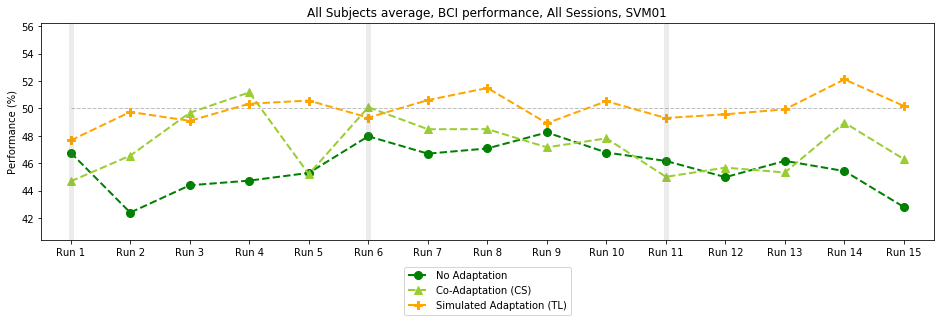

In [14]:
fig = plt.figure(figsize=(16,4))

plt.plot(no_adaptation_means, color='green', marker='o', markersize=8,
         linestyle='dashed', linewidth=2)
#plt.errorbar()
plt.plot(co_adaptation_means, color='yellowgreen', marker='^', markersize=8,
     linestyle='dashed', linewidth=2)
plt.plot(sim_TL_scores_means, color='orange', marker='P', markersize=8,
     linestyle='dashed', linewidth=2)
plt.title('All Subjects average, BCI performance, All Sessions, ' + model_type)
lgd = plt.legend(['No Adaptation','Co-Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
          loc='upper center', bbox_to_anchor=(0.5, -0.10))
# Plot properties
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
           ['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6','Run 7','Run 8','Run 9','Run 10',
           'Run 11','Run 12','Run 13','Run 14','Run 15'])
plt.ylabel('Performance (%)')
plt.hlines(y=50, xmin=0, xmax=14, color='gray', linestyles='dashed',
           linewidth=1, alpha=0.5)
plt.axvline(x=0, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=5, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=10, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.ylim([min_all-2, max_all+2])
plt.xlim([-0.5,14.5])

plt.show()
fig.savefig('Figures/' + subjID + '_Performance_Session-all_' + model_type + '.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

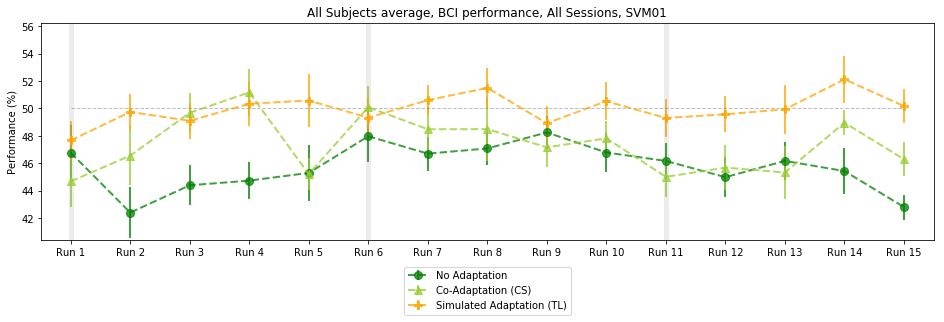

In [15]:
fig = plt.figure(figsize=(16,4))
x = np.asarray(range(0,15))

plt.errorbar(x, no_adaptation_means, no_adaptation_sem, color='green', marker='o', markersize=8,
         linestyle='dashed', linewidth=2, alpha=0.75)
plt.errorbar(x,co_adaptation_means, co_adaptation_sem, color='yellowgreen', marker='^', markersize=8,
     linestyle='dashed', linewidth=2, alpha=0.75)
plt.errorbar(x,sim_TL_scores_means, sim_TL_scores_sem, color='orange', marker='P', markersize=8,
     linestyle='dashed', linewidth=2, alpha=0.75)
plt.title('All Subjects average, BCI performance, All Sessions, ' + model_type)
lgd = plt.legend(['No Adaptation','Co-Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
          loc='upper center', bbox_to_anchor=(0.5, -0.10))
# Plot properties
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
           ['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6','Run 7','Run 8','Run 9','Run 10',
           'Run 11','Run 12','Run 13','Run 14','Run 15'])
plt.ylabel('Performance (%)')
plt.hlines(y=50, xmin=0, xmax=14, color='gray', linestyles='dashed',
           linewidth=1, alpha=0.5)
plt.axvline(x=0, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=5, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.axvline(x=10, alpha=0.15, linewidth=5, color='gray', linestyle='solid')
plt.ylim([min_all-2, max_all+2])
plt.xlim([-0.5,14.5])

plt.show()
fig.savefig('Figures/' + subjID + '_Performance_Session-all_' + model_type + '-withSEM.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')